# Generate single band image of a lensed source

In [1]:
import os
import sys
import pickle as pkl
import h5py
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel

from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util import util
from slitronomy.Util.plot_util import nice_colorbar

from util import galaxy_util, denoising_util

np.random.seed(18)

%matplotlib inline

In [2]:
#galsim_index_list = [1, 5, 22, 23, 29, 31, 56, 59, 63, 69]
galsim_index_list = [5, 29, 31]
save_files = True
save_resolutions = False

# noise settings
snr_dB = 500
background_rms = None  # noise added as SNR
exp_time = None #400

In [3]:
save_basedir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/ring_sims/'
if snr_dB is not None:
    save_subdir = 'sims_SNR{}'.format(snr_dB)
elif background_rms is not None and exp_time is None:
    save_subdir = 'sims_bkg{}'.format(background_rms)
elif background_rms is not None and exp_time is not None:
    save_subdir = 'sims_bkg{}_poisson{}'.format(background_rms, exp_time)

# create directory for saving files 
save_dir = os.path.join(save_basedir, save_subdir)
if not os.path.exists(save_dir) and save_files:
    os.makedirs(save_dir)

def save_fits(data, file_path, overwrite=True):
    hdu = pf.PrimaryHDU(data)
    hdu.writeto(file_path, overwrite=overwrite)
    print("FITS file successfully saved to", file_path)
    
def dump_pickle(data, path, protocol=None):
    if protocol is None:
        protocol = 2
    with open(path, 'wb') as handle:
        pkl.dump(data, handle, protocol=protocol)

def save_hdf5(data_dict, path):
    with h5py.File(path, "w") as f:
        for name, data in data_dict.items():
            dset = f.create_dataset(name, data=data)
            
def noise_with_SNR(snr_db, image):
    sigma = np.linalg.norm(image.flatten(), 2) / snr_db
    noise = sigma * np.random.randn(*image.shape)
    return noise, sigma

In [4]:
def generate_ring(num_pix, delta_pix, source_type='galsim', supersampling_factor_numerics=3, galsim_index=31, scale=1,
                  psf_num_pix=41, psf_fwhm=0.2, source_amp=1, background_rms=None, noise_snr=None, exp_time=None,
                  ra_source=0, dec_source=0):  # in delta_pix units):

    num_pix_source = int(num_pix * supersampling_factor_numerics)
    delta_pix_source = delta_pix / supersampling_factor_numerics

    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
        = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, inverse=False)
    
    kwargs_data = {
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
        'transform_pix2angle': Mpix2coord,
        'image_data': np.zeros((num_pix, num_pix))
    }
    if exp_time is not None:
        kwargs_data['exposure_time'] = np.ones((num_pix, num_pix)) * exp_time
    
    data_class = ImageData(**kwargs_data)

    # PSF specification
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    psf_class = PSF(**kwargs_psf)

    lens_model_list = ['PEMD']
    kwargs_pemd = {'gamma': 2, 'theta_E': 1.8, 'center_x': 0.1, 'center_y': 0.1, 'e1': -0.1, 'e2': 0.2}
    kwargs_lens = [kwargs_pemd]#, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list)

    # list of light profiles (for lens and source)
    # 'SERSIC': spherical Sersic profile
    lens_light_model_list = [] # ['SERSIC']
    kwargs_sersic = {'amp': 200., 'R_sersic': 10., 'n_sersic': 1, 'center_x': num_pix/2., 'center_y': num_pix/2.}
    kwargs_lens_light = [] # [kwargs_sersic]
    lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

    # interpolation from  an image
    source_model_list = ['INTERPOL']
    source_image, _, _ = galaxy_util.get_galsim_image(num_pix_source, delta_pix_source,
                                                   catalog_dir='/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/divers/GalSim-releases-2.2/examples/data', 
                                                   catalog_name='real_galaxy_catalog_23.5_example.fits',
                                                   catalog_index=galsim_index, galsim_scale=scale, 
                                                   psf_size=49, psf_pixel_size=0.074, galaxy_type='real',
                                                   psf_type='gaussian', psf_gaussian_fwhm=0.2, no_convolution=False,
                                                   draw_image_method='auto', cut_negative_flux=True,
                                                    verbose=False)
    source_image /= source_image.max() # standardize image
    source_denoising = False
    if source_denoising is True:
        # simple rough denoising denoising
        source_image = denoising_util.starlets_denoising(source_image, threshold_level=0.5)
    kwargs_interpol = {'image': source_image, 'amp': source_amp, 'scale': delta_pix_source, 
                       'phi_G': 0, 'center_x': ra_source, 'center_y': dec_source}
    kwargs_source = [kwargs_interpol]
    source_model_class = LightModel(light_model_list=source_model_list)

    kwargs_numerics = {'supersampling_factor': supersampling_factor_numerics, 'supersampling_convolution': False}
    
    # the ray-tracing will be performed parametrically
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                            kwargs_numerics=kwargs_numerics)

    image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
    
    if background_rms is not None:
        bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
    else:
        bkg, sigma = noise_with_SNR(snr_dB, image_sim_no_noise)
        background_rms = sigma
    if exp_time is not None:
        poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
        
    noise = bkg if exp_time is None else bkg + poisson
    image_sim = image_sim_no_noise + noise

    kwargs_data['image_data'] = image_sim
    kwargs_data['background_rms'] = background_rms
    if exp_time is not None:
        kwargs_data['exposure_time'] = exp_time
    else:
        kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
    
    data_class_updated = ImageData(**kwargs_data)
    noise_map = np.sqrt(data_class_updated.C_D)
    
    # save galsim and interpolated source images at different resolutions
    source_interpol_list, source_galsim_list = [], []
    for ss_factor in range(1, supersampling_factor_numerics+1):
        num_pix_source, delta_pix_source = int(num_pix*ss_factor), delta_pix/ss_factor
        
        # get lenstronomy-interpolated source at required resolution
        x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix_source, 
                                                              deltapix=delta_pix_source)
        source_interpol = util.array2image(source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source))
        source_interpol *= delta_pix_source**2  # fix units, like in lenstronomy's re_size_convolve() method
        source_interpol_list.append(source_interpol)
        
        # get galsim source at required resolution
        source_galsim, _, _ = galaxy_util.get_galsim_image(num_pix_source, delta_pix_source,
                                                   catalog_dir='/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/divers/GalSim-releases-2.2/examples/data', 
                                                   catalog_name='real_galaxy_catalog_23.5_example.fits',
                                                   catalog_index=galsim_index, galsim_scale=scale, 
                                                   psf_size=49, psf_pixel_size=0.074, galaxy_type='real',
                                                   psf_type='gaussian', psf_gaussian_fwhm=0.2, no_convolution=False,
                                                   draw_image_method='auto', cut_negative_flux=True,
                                                           verbose=False)
        source_galsim /= source_galsim.max()
        source_galsim *= source_amp
        source_galsim *= delta_pix_source**2  # fix units, like in lenstronomy's re_size_convolve() method
        source_galsim_list.append(source_galsim)
    
    # 'true' source used for the model (the one being lensed)
    source_sim = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, unconvolved=True, de_lensed=True)
    
    # wrap up in dictionaries
    data = {
        'num_pix': num_pix,
        'delta_pix': delta_pix,
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 'transform_pix2angle': Mpix2coord,
        'background_rms': background_rms,
        'noise_map': noise_map,
        'supersampling_factor_numerics': supersampling_factor_numerics,
        'image_sim': image_sim,
        'image_sim_no_noise': image_sim_no_noise,
        'psf_kernel': psf_kernel, 
        'ra_source': ra_source,
        'dec_source': dec_source,
    }
    lens_model = {
        'lens_model_list': lens_model_list,
        'kwargs_lens': kwargs_lens,
    }
    truth = {
        'source_sim': source_sim,
    }
    truth['num_source_res'] = len(source_interpol_list)
    for i in range(len(source_interpol_list)):
        truth['source_galsim_'+str(i+1)] = source_galsim_list[i]
        truth['source_interpol_'+str(i+1)] = source_interpol_list[i]
    return data, truth, lens_model


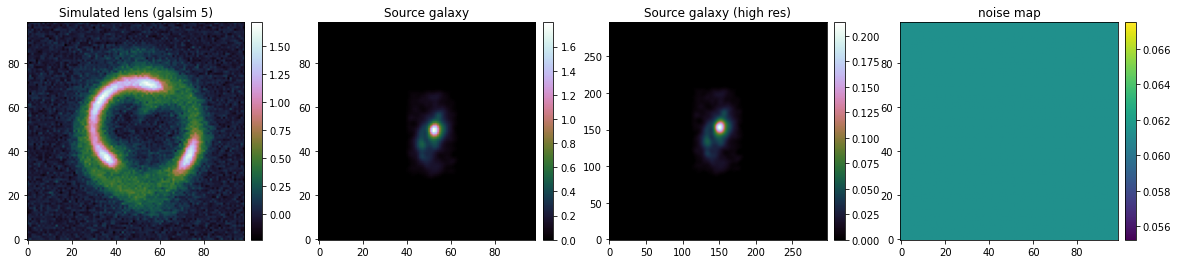

FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/ring_sims/sims_SNR500/simring_galsim5_image.fits


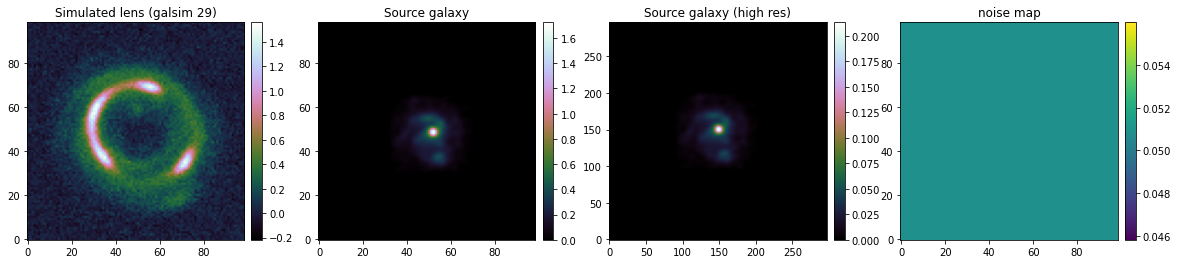

FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/ring_sims/sims_SNR500/simring_galsim29_image.fits


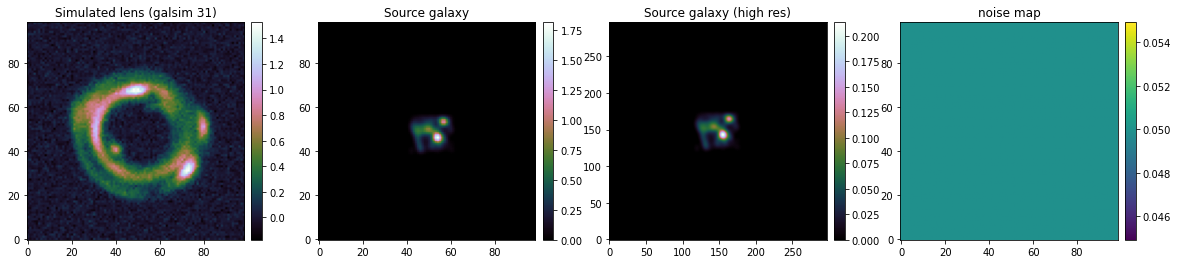

FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/ring_sims/sims_SNR500/simring_galsim31_image.fits


In [5]:
num_pix = 99
delta_pix = 0.08
ra_source = 0.2
dec_source = -0.1

for galsim_index in galsim_index_list:
    data, truth, lens_model = generate_ring(num_pix, delta_pix, galsim_index=galsim_index, scale=1.2,
                                            source_amp=300, background_rms=background_rms, noise_snr=snr_dB, exp_time=exp_time,
                                            ra_source=ra_source, dec_source=dec_source)
    image_sim = data['image_sim']
    source_sim = truth['source_sim']
    num_source_res = truth['num_source_res']
    source_galsim = truth['source_galsim_'+str(num_source_res)]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    ax = axes[0]
    ax.set_title("Simulated lens (galsim {})".format(galsim_index))
    im = ax.imshow(image_sim, origin='lower', cmap='cubehelix')
    #ax.scatter(numPix/2., numPix/2., color='blue', marker='.', s=40, alpha=0.5) # center of the image
    nice_colorbar(im)

    ax = axes[1]
    ax.set_title("Source galaxy")
    im = ax.imshow(source_sim, origin='lower', cmap='cubehelix')
    nice_colorbar(im)

    ax = axes[2]
    ax.set_title("Source galaxy (high res)")
    im = ax.imshow(source_galsim, origin='lower', cmap='cubehelix')
    #ax.scatter(num_pix/2., num_pix/2., color='green', marker='+', s=120) # center of the image
    nice_colorbar(im)
    
    ax = axes[3]
    ax.set_title("noise map")
    im = ax.imshow(data['noise_map'], origin='lower', cmap='viridis')
    nice_colorbar(im)
    
    plt.show()
    
    if save_files:
        base_string = "galsim{}".format(galsim_index)
        dump_pickle([data, truth, lens_model], os.path.join(save_dir, "simring_{}_all.pkl".format(base_string)))
        save_fits(image_sim, os.path.join(save_dir, "simring_{}_image.fits".format(base_string)))
        fig.savefig(os.path.join(save_dir, "preview_simring_{}_image.png".format(base_string)))
        # save true source at different resolutions in separate fits files
        if save_resolutions:
            save_dir_parent = os.path.dirname(save_dir)
            for res in range(1, num_source_res+1):
                file_name_res = f"source_{base_string}_pixsize{int(delta_pix*1000)}mas_ssres{res}.fits"
                save_fits(truth['source_galsim_'+str(res)], os.path.join(save_dir_parent, file_name_res))
